In [12]:
import re, json, time
from selenium import webdriver

# import By
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

# from webdriver_manager.chrome import ChromeDriverManager
from parsel import Selector

import pandas as pd
import numpy as np


def scroll_page(url):
    # service = Service(ChromeDriverManager().install())

    # options = webdriver.ChromeOptions()
    # options.add_argument("--headless")
    # options.add_argument("--lang=en")
    # options.add_argument(
    #     "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36"
    # )

    driver = webdriver.Chrome()
    driver.get(url)

    # old_height = driver.execute_script(
    #     """
    #     function getHeight() {
    #         return document.querySelector('ytd-app').scrollHeight;
    #     }
    #     return getHeight();
    # """
    # )

    # while True:
    #     driver.execute_script(
    #         "window.scrollTo(0, document.querySelector('ytd-app').scrollHeight)"
    #     )

    #     time.sleep(2)

    #     new_height = driver.execute_script(
    #         """
    #         function getHeight() {
    #             return document.querySelector('ytd-app').scrollHeight;
    #         }
    #         return getHeight();
    #     """
    #     )

    #     if new_height == old_height:
    #         break

    #     old_height = new_height

    time.sleep(2)
    selector = Selector(driver.page_source)
    driver.quit()

    return selector


def scrape_all_data(selector):
    youtube_video_page = []

    all_script_tags = selector.css("script").getall()

    title = selector.css(".title .ytd-video-primary-info-renderer::text").get()

    # https://regex101.com/r/gHeLwZ/1
    views = int(
        re.search(r"(.*)\s", selector.css(".view-count::text").get())
        .group()
        .replace(",", "")
    )

    # https://regex101.com/r/9OGwJp/1
    likes = int(
        re.search(
            r"(.*)\s",
            selector.css(
                "#top-level-buttons-computed > ytd-toggle-button-renderer:first-child #text::attr(aria-label)"
            ).get(),
        )
        .group()
        .replace(",", "")
    )

    date = selector.css("#info-strings yt-formatted-string::text").get()

    duration = selector.css(".ytp-time-duration::text").get()

    # https://regex101.com/r/0JNma3/1
    keywords = (
        "".join(
            re.findall(r'"keywords":\[(.*)\],"channelId":".*"', str(all_script_tags))
        )
        .replace('"', "")
        .split(",")
    )

    # https://regex101.com/r/9VhH1s/1
    thumbnail = re.findall(
        r'\[{"url":"(\S+)","width":\d*,"height":\d*},', str(all_script_tags)
    )[0].split('",')[0]

    channel = {
        # https://regex101.com/r/xFUzq5/1
        "id": "".join(
            re.findall(r'"channelId":"(.*)","isOwnerViewing"', str(all_script_tags))
        ),
        "name": selector.css("#channel-name a::text").get(),
        "link": f'https://www.youtube.com{selector.css("#channel-name a::attr(href)").get()}',
        "subscribers": selector.css("#owner-sub-count::text").get(),
        "thumbnail": selector.css("#img::attr(src)").get(),
    }

    description = selector.css(
        ".ytd-expandable-video-description-body-renderer span:nth-child(1)::text"
    ).get()

    hash_tags = [
        {
            "name": hash_tag.css("::text").get(),
            "link": f'https://www.youtube.com{hash_tag.css("::attr(href)").get()}',
        }
        for hash_tag in selector.css(
            ".ytd-expandable-video-description-body-renderer a"
        )
    ]

    # https://regex101.com/r/onRk9j/1
    category = "".join(
        re.findall(r'"category":"(.*)","publishDate"', str(all_script_tags))
    )

    comments_amount = int(
        selector.css("#count .count-text span:nth-child(1)::text")
        .get()
        .replace(",", "")
    )

    comments = []

    for comment in selector.css("#contents > ytd-comment-thread-renderer"):
        comments.append(
            {
                "author": comment.css("#author-text span::text").get().strip(),
                "link": f'https://www.youtube.com{comment.css("#author-text::attr(href)").get()}',
                "date": comment.css(".published-time-text a::text").get(),
                "likes": comment.css("#vote-count-middle::text").get().strip(),
                "comment": comment.css("#content-text::text").get(),
                "avatar": comment.css("#author-thumbnail #img::attr(src)").get(),
            }
        )

    suggested_videos = []

    for video in selector.css("ytd-compact-video-renderer"):
        suggested_videos.append(
            {
                "title": video.css("#video-title::text").get().strip(),
                "link": f'https://www.youtube.com{video.css("#thumbnail::attr(href)").get()}',
                "channel_name": video.css("#channel-name #text::text").get(),
                "date": video.css("#metadata-line span:nth-child(2)::text").get(),
                "views": video.css("#metadata-line span:nth-child(1)::text").get(),
                "duration": video.css("#overlays #text::text").get().strip(),
                "thumbnail": video.css("#thumbnail img::attr(src)").get(),
            }
        )

    youtube_video_page.append(
        {
            "title": title,
            "views": views,
            "likes": likes,
            "date": date,
            "duration": duration,
            "channel": channel,
            "keywords": keywords,
            "thumbnail": thumbnail,
            "description": description,
            "hash_tags": hash_tags,
            "category": category,
            "suggested_videos": suggested_videos,
            "comments_amount": comments_amount,
            "comments": comments,
        }
    )

    print(json.dumps(youtube_video_page, indent=2, ensure_ascii=False))


def get_info_from_video(selector) -> dict[str, str | int]:
    # title
    title = selector.css(
        "yt-formatted-string.style-scope.ytd-watch-metadata::text"
    ).get()

    # date

    date = selector.css("#info-strings yt-formatted-string::text").get()
    # date = selector.css(
    #     "yt-formatted-string#info span.style-scope.ytd-watch-metadata:nth-child(3)::text"
    # ).get()

    # views
    views = selector.css("span.bold.style-scope.yt-formatted-string::text").get()

    # likes
    likes = selector.css(
        "#segmented-like-button > ytd-toggle-button-renderer > yt-button-shape > button::attr(aria-label)"
    ).get()

    # comments
    try:
        comments_amount = int(
            selector.css("#count .count-text span:nth-child(1)::text")
            .get()
            .replace(",", "")
        )
    except Exception as e:
        comments_amount = 0

    # keywords
    all_script_tags = selector.css("script").getall()
    keywords = (
        "".join(
            re.findall(r'"keywords":\[(.*)\],"channelId":".*"', str(all_script_tags))
        )
        .replace('"', "")
        .split(",")
    )

    print(title, views, likes, date, comments_amount, keywords)

    try:
        likes = re.search(r"(\d+)", likes).group()
    except Exception as e:
        likes = 0
    # views = re.search(r"(\d+)", views).group()

    return pd.DataFrame.from_dict(
        {
            "title": [title],
            "views": [views],
            "likes": [likes],
            "date": [date],
            "comments_amount": [comments_amount],
            "keywords": [keywords],
        }
    )


def parse_channel(selector) -> pd.DataFrame:
    subscribers = selector.css(
        "#subscriber-count.style-scope.ytd-c4-tabbed-header-renderer::text"
    ).get()

    # subscribers = re.search(r"(\d+)", subscribers).group()

    # get recent 5 videos
    channel_name = selector.css(
        "div#channel-header-container yt-formatted-string#text::text"
    ).get()

    videos = selector.css(
        "div.style-scope.ytd-rich-item-renderer ytd-rich-grid-media div.style-scope.ytd-rich-grid-media a#thumbnail.yt-simple-endpoint.inline-block.style-scope.ytd-thumbnail::attr(href)"
    ).getall()[:5]

    u, ind = np.unique(videos, return_index=True)
    videos = u[np.argsort(ind)]

    df = pd.DataFrame()
    for v in videos:
        print("Video: ", v)

        result = scroll_page(f"https://www.youtube.com{v}")

        info = get_info_from_video(result)
        info["channel_name"] = channel_name
        info["subscribers"] = subscribers
        # print(info)

        df = pd.concat([df, info])
        # df = df.append(info, ignore_index=True)

    print("Videos i got: ", len(videos))
    return df


def parse_top_channel(channel_link: str) -> pd.DataFrame:
    from selenium.webdriver.support.ui import WebDriverWait
    from selenium.webdriver.support import expected_conditions as EC
    from selenium.webdriver.common.by import By

    driver = webdriver.Chrome()
    wait = WebDriverWait(driver, 10)

    driver.get(channel_link)
    driver.maximize_window()

    # //*[@id="chips"]/yt-chip-cloud-chip-renderer[2]
    # wait for page to load
    wait.until(
        EC.presence_of_element_located(
            (By.XPATH, '//*[@id="chips"]/yt-chip-cloud-chip-renderer[2]')
        )
    ).click()
    time.sleep(2)

    selector = Selector(text=driver.page_source)
    driver.quit()

    channel_name = selector.css(
        "div#channel-header-container yt-formatted-string#text::text"
    ).get()

    videos = selector.css(
        "div.style-scope.ytd-rich-item-renderer ytd-rich-grid-media div.style-scope.ytd-rich-grid-media a#thumbnail.yt-simple-endpoint.inline-block.style-scope.ytd-thumbnail::attr(href)"
    ).getall()[:5]

    u, ind = np.unique(videos, return_index=True)
    videos = u[np.argsort(ind)]

    df = pd.DataFrame()
    for v in videos:
        print("Video: ", v)

        result = scroll_page(f"https://www.youtube.com{v}")

        info = get_info_from_video(result)
        print(info)
        info["channel_name"] = channel_name
        # print(info)

        df = pd.concat([df, info])
        # df = df.append(info, ignore_index=True)

    print("Videos i got: ", len(videos))
    return df

In [13]:
canais = [
    "https://www.youtube.com/@macformarketing",
    "https://www.youtube.com/@Media.MonksBrasil",
    "https://www.youtube.com/@GhFly",
    "https://www.youtube.com/@Cadastra",
]

df = pd.DataFrame()
df_top = pd.DataFrame()
for ch in canais:
    # recent videos
    result = scroll_page(ch + "/videos")
    df_channel = parse_channel(result)
    df = pd.concat([df, df_channel])

    # top videos
    df_top_channel = parse_top_channel(ch + "/videos")
    df_top = pd.concat([df_top, df_top_channel])


df.to_csv("videos.csv", index=False)
df_top.to_csv("top_videos.csv", index=False)

Video:  /watch?v=_2JKHa8H2Dw
Marketing de sucesso no B2B e B2B2C | Guilherme Moraes | BRING ME DATA #12 25 visualizações Marque este vídeo como "Gostei" com mais 5 pessoas 16 de jun. de 2023 0 ['']
Video:  /watch?v=JT0dDZCkmpc
Como ser um gestor e um líder de sucesso | Rodrigo Lemos | BRING ME DATA #11 46 visualizações Marque este vídeo como "Gostei" com mais 4 pessoas 18 de mai. de 2023 0 ['']
Video:  /watch?v=fanZL3nnn8U
SEO: inovações e o que mudou com as IAs | John Martin | BRING ME DATA #10 151 visualizações Marque este vídeo como "Gostei" com mais 13 pessoas 12 de abr. de 2023 0 ['']
Video:  /watch?v=9DC4cTqVNsQ
“Marketing digital não existe” | Ricardo Poli | BRING ME DATA #9 150 visualizações Marque este vídeo como "Gostei" com mais 9 pessoas 23 de mar. de 2023 0 ['']
Video:  /watch?v=8_mHXhuMioc
O essencial para aprimorar seu processo de vendas B2B | Arthur Viana | BRING ME DATA #8 69 visualizações Marque este vídeo como "Gostei" com mais 2 pessoas 14 de mar. de 2023 0 ['']
Vid

# Tratamento

In [53]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

'pt_BR.UTF-8'

In [54]:
videos = pd.read_csv("videos.csv")

In [97]:
def trata_inscritos(col: pd.Series) -> pd.Series:
    col = col.split(" inscritos")[0]

    if "mil" in col:
        return int(
            float(col.replace("mil", "").replace(" ", "").replace(",", ".")) * 1000
        )

    return int(col.replace(" ", "").replace(",", "."))


def trata_visualizacoes(col: pd.Series) -> pd.Series:
    # treat the characters U+00a0
    col = col.replace("\xa0", "")
    col = col.split(" visualizações")[0]

    if "mil" in col:
        return int(
            float(col.replace("mil", "").replace(" ", "").replace(",", ".")) * 1000
        )
    elif "mi" in col:
        # remove 'de'
        if 'de' in col:
            col = col.replace('de', '')
        return int(
            float(col.replace("mi", "").replace(" ", "").replace(",", ".")) * 1000000
        )

    return int(col.replace(" ", "").replace(",", "."))


def trata_data(col: pd.Series) -> pd.Series:
    
    return pd.to_datetime(col.str.replace('. de', ''), format='%d de %b %Y')

In [100]:
videos.assign(
    subscribers=lambda df_: df_["subscribers"].apply(trata_inscritos),
    views=lambda df_: df_["views"].apply(trata_visualizacoes),
    date=lambda df_: trata_data(df_["date"]),
    category = 'RECENT'
).to_parquet("videos.parquet")

top videos

In [62]:
top_videos = pd.read_csv("top_videos.csv")

In [101]:
top_videos.assign(
    date=lambda df_: trata_data(df_["date"]),
    views=lambda df_: df_["views"].apply(trata_visualizacoes),
    category = 'TOP'
).to_parquet("top_videos.parquet")

# join

In [102]:
videos = pd.read_parquet("videos.parquet")
top_videos = pd.read_parquet("top_videos.parquet")

In [105]:
# join the two dataframes

videos = pd.concat([videos, top_videos])

In [109]:
videos_sorted = videos.sort_values('channel_name')

videos_sorted['subscribers'] = videos_sorted['subscribers'].fillna(method='ffill')

In [113]:
videos_sorted = videos_sorted.sort_values(['channel_name', 'category', 'date'])

In [116]:
videos_sorted.to_parquet("videos_sorted.parquet")

In [118]:
import polars as pl

<Axes: title={'center': 'Views and Likes by Channel'}, ylabel='channel_name'>

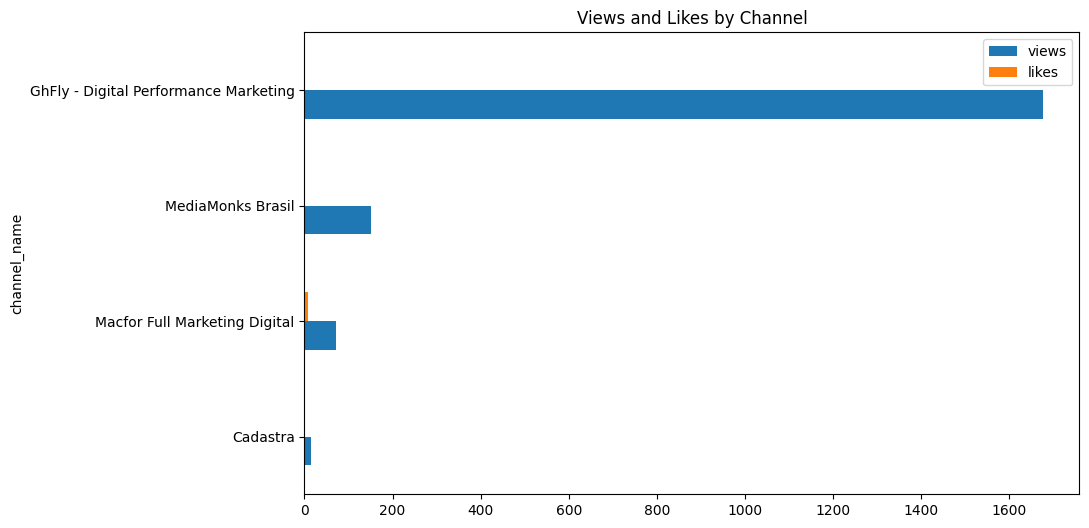

In [138]:
from datetime import datetime
(pl.read_parquet("videos_sorted.parquet")
 # last 30 days
 .filter(pl.col('date') > datetime(2023, 5, 1))
 .groupby('channel_name')
 .agg(
        pl.sum('views').alias('views'),
        pl.sum('likes').alias('likes'),
 )
 .sort(['views','likes'], descending=False)
 ).to_pandas()\
 .plot.barh(figsize=(10, 6), x='channel_name', title='Views and Likes by Channel')